In [191]:
import pandas as pd
import numpy as np

In [192]:
pd.set_option('precision',2)

In [193]:
get_ipython().magic('matplotlib inline')
import matplotlib.pylab as plt
import seaborn as sns
import ggplot as gg
from ggplot import *
import bokeh as bkh

In [246]:
# dataset from https://www.kaggle.com/kaggle/sf-salaries
sf2014 = pd.read_csv('data/sf-salaries/Salaries.csv', usecols=[0,1,2,3,4,5,6,7,9,11,12], dtype={3: object, 4: object, 5: object, 6: object, 12: object}, na_values=['Not Provided', 'Not provided', 'not provided'])

# dataset from http://transparentcalifornia.com/salaries/2015/san-francisco/
sf2015 = pd.read_csv('data/sf-salaries/san-francisco-2015.csv')

#### na_values=['Not Provided', 'Not provided', 'not provided']

In [247]:
# Combine the 2011-2014 dataset with 2015
sf = pd.concat([sf2014, sf2015], ignore_index=True)


## Defination of the columns:

### Numeric (needs conversion to numeric):
##### 1. BasePay, OvertimePay, OtherPay, Benefits, TotalPay

### Categorical:
##### 1. Id, EmployeeName, JobTitle, Agency, Status


In [252]:
sf2014.head()

### MENTOR ### Notice that the *sf 2011-2014" doesnt not have $ in TotalPay

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,NaN,567595.43,2011,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,2011,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.6,NaN,335279.91,2011,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.0,56120.71,198306.9,NaN,332343.61,2011,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.6,9737.0,182234.59,NaN,326373.19,2011,San Francisco,NaN


In [250]:
sf2015.head()

### MENTOR ### Notice that the *sf 2015" doesnt not have $ in TotalPay

,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Notes,Agency,Status
0,William J Coaker Jr.,Chief Investment Officer,"$507,831.60",$0.00,$0.00,"$125,891.73","$507,831.60",2015,NaN,San Francisco,FT
1,Ellen G Moffatt,Asst Med Examiner,"$279,311.10","$3,829.36","$114,433.58","$72,446.93","$397,574.04",2015,NaN,San Francisco,FT
2,Amy P Hart,Asst Med Examiner,"$279,311.03","$9,046.92","$56,742.56","$75,784.61","$345,100.51",2015,NaN,San Francisco,FT
3,Gregory P Suhr,Chief of Police,"$308,901.44",$0.00,"$19,354.12","$82,682.53","$328,255.56",2015,NaN,San Francisco,FT
4,Joanne M Hayes-White,"Chief, Fire Department","$303,494.81",$0.00,"$24,279.58","$82,294.94","$327,774.39",2015,NaN,San Francisco,FT


## Starting Analysis

* Agency - Represents a region in the larger datasets.
* BasePay - The base rate of pay for a job or activity, excluding additional payments such as overtime or bonuses.
* Benefits - Employees pension plan, free health insurance, and other benefits.
* EmployeeName - Full Name (we can try to use this to analyze gender discrimination)
* Id - Original order of employees from sf2014 dataset, field does not exist in sf 2015
* JobTitle - Employee position held. (There seem to be differences in naming between datasets.)
* Notes - Empty
* OtherPay - Not sure but I would imagine Bonuses or other 'special' benefits. Could include personal flights on public aircrafts.
* OvertimePay - Time paid at California's's 1.5x base pay for over time.
* Status - Classification as FT (Full Time) or PT (Part Time) employee. Only tracked after 2013.
* TotalPay - BasePay + OvertimePay + OtherPay
* Year - Payroll year

In [258]:
sf.reset_index()

,index,Agency,BasePay,Benefits,EmployeeName,Id,JobTitle,Notes,OtherPay,OvertimePay,Status,TotalPay,Year
0,0,San Francisco,167411.18,NaN,NATHANIEL FORD,1.0,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,NaN,400184.25,0.0,NaN,5.7e+05,2011
1,1,San Francisco,155966.02,NaN,GARY JIMENEZ,2.0,CAPTAIN III (POLICE DEPARTMENT),NaN,137811.38,245131.88,NaN,5.4e+05,2011
2,2,San Francisco,212739.13,NaN,ALBERT PARDINI,3.0,CAPTAIN III (POLICE DEPARTMENT),NaN,16452.6,106088.18,NaN,3.4e+05,2011
3,3,San Francisco,77916.0,NaN,CHRISTOPHER CHONG,4.0,WIRE ROPE CABLE MAINTENANCE MECHANIC,NaN,198306.9,56120.71,NaN,3.3e+05,2011
4,4,San Francisco,134401.6,NaN,PATRICK GARDNER,5.0,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",NaN,182234.59,9737.0,NaN,3.3e+05,2011
5,5,San Francisco,118602.0,NaN,DAVID SULLIVAN,6.0,ASSISTANT DEPUTY CHIEF II,NaN,189082.74,8601.0,NaN,3.2e+05,2011
6,6,San Francisco,92492.01,NaN,ALSON LEE,7.0,"BATTALION CHIEF, (FIRE DEPARTMENT)",NaN,134426.14,89062.9,NaN,3.2e+05,2011
7,7,San Francisco,256576.96,NaN,DAVID KUSHNER,8.0,DEPUTY DIRECTOR OF INVESTMENTS,NaN,51322.5,0.0,NaN,3.1e+05,2011
8,8,San Francisco,176932.64,NaN,MICHAEL MORRIS,9.0,"BATTALION CHIEF, (FIRE DEPARTMENT)",NaN,40132.23,86362.68,NaN,3e+05,2011
9,9,San Francisco,285262.0,NaN,JOANNE HAYES-WHITE,10.0,"CHIEF OF DEPARTMENT, (FIRE DEPARTMENT)",NaN,17115.73,0.0,NaN,3e+05,2011


In [253]:
sf.isnull().sum()

Agency               0
BasePay            609
Benefits         36163
EmployeeName         6
Id               39380
JobTitle             4
Notes           188034
OtherPay             4
OvertimePay          4
Status          110535
TotalPay             0
Year                 0
dtype: int64

In [201]:
sf.Agency.unique()

array(['San Francisco'], dtype=object)

Since the Agency field only contains one unique value, I will remove the field. Notices field is null.

In [262]:
del sf['Notes']

# Here is another way of dropping a field.

sf.drop(['Agency'], axis=1, inplace=True)

KeyError: 'Notes'

Here I am going to do basic data standardization and cleaning so that it is easier to work with this dataset.

In [207]:
# I am also going to delete any observation where JobTitle is 'Not provided' so that the field can be indexed
sf = sf[sf.JobTitle.notnull()]

# Filling in 'Benefits' if NaN, fill with 0
sf['Benefits'].fillna(0, inplace=True)

# Replace NaN status with "Unknown", since we don't know if its FT or PT work, easier categorization later.
sf['Status'].fillna("Unknown", inplace=True)

# Convert all JobTitle to upper-case character so there is no differentiation in data.
sf['JobTitle'] = sf.JobTitle.str.upper()

# Convert all EmployeeName to upper-case character so there is no differentiation in data. 
# Note: I noticed in pivots duplicate entries if the letter is not standardized.
sf['EmployeeName'] = sf.EmployeeName.str.upper()

In [204]:
# Much cleaner now
sf.isnull().sum()

BasePay           605
Benefits            0
EmployeeName        2
Id              39380
JobTitle            0
OtherPay            0
OvertimePay         0
Status              0
TotalPay            0
Year                0
dtype: int64

From reading on the website (where I pulled the dataset) I already saw that there records with zero BasePay, but instead amounts appear in OtherPay and TotalPay, thus 605 null BasePay records does not suprise me.

For Id column I already know that the sf2015 dataset doesnt have an Id column.

In [263]:
sf.BasePay = sf.BasePay.str.lstrip('$')
sf.OtherPay = sf.OtherPay.str.lstrip('$')

# This is the problem area where the first $ shows up with ','
# sf[148650's:]

sf.TotalPay[148650:]

148650               0
148651               0
148652               0
148653        -6.2e+02
148654    $507,831.60 
148655    $397,574.04 
148656    $345,100.51 
148657    $328,255.56 
148658    $327,774.39 
148659    $326,764.01 
148660    $338,390.32 
148661    $337,894.92 
148662    $320,480.00 
148663    $307,580.34 
148664    $323,569.97 
148665    $304,000.40 
148666    $317,435.90 
148667    $299,121.51 
148668    $330,205.58 
148669    $310,743.63 
148670    $307,202.45 
148671    $288,963.55 
148672    $288,842.82 
148673    $288,949.26 
148674    $305,402.06 
148675    $316,965.83 
148676    $294,739.25 
148677    $283,603.65 
148678    $298,551.48 
148679    $279,570.67 
              ...     
188004         $47.95 
188005         $40.63 
188006         $47.03 
188007         $46.50 
188008         $46.22 
188009         $37.37 
188010         $44.91 
188011         $44.75 
188012         $42.69 
188013         $40.33 
188014         $39.05 
188015         $38.80 
188016     

In [217]:
sf.BasePay = sf.BasePay.str.lstrip('$')
sf.OtherPay = sf.OtherPay.str.lstrip('$')
sf.OvertimePay = sf.OvertimePay.str.lstrip('$')
sf.TotalPay = sf.TotalPay.str.lstrip('$')
sf.Benefits = sf.Benefits.str.lstrip('$')

In [220]:
sf.BasePay = sf.BasePay.str.replace(',','')
sf.OtherPay = sf.OtherPay.str.replace(',','')
sf.OvertimePay = sf.OvertimePay.str.replace(',','')
sf.TotalPay = sf.TotalPay.str.replace(',','')
sf.Benefits = sf.Benefits.str.replace(',','')

In [222]:
sf.BasePay = pd.to_numeric(sf.BasePay)
sf.OvertimePay = pd.to_numeric(sf['OvertimePay'])
sf.OtherPay = pd.to_numeric(sf['OtherPay'])
sf.Benefits = pd.to_numeric(sf['Benefits'])
sf.TotalPay = pd.to_numeric(sf['TotalPay'])



# sf['BasePay'] = pd.to_numeric(sf['BasePay'])
# sf['OvertimePay'] = pd.to_numeric(sf['OvertimePay'])
# sf['OtherPay'] = pd.to_numeric(sf['OtherPay'])
# sf['Benefits'] = pd.to_numeric(sf['Benefits'])
# sf['TotalPay'] = pd.to_numeric(sf['TotalPay'])

In [224]:
sf.dtypes

BasePay         float64
Benefits        float64
EmployeeName     object
Id              float64
JobTitle         object
OtherPay        float64
OvertimePay     float64
Status           object
TotalPay        float64
Year              int64
dtype: object

In [225]:
sf.describe()

,BasePay,Benefits,Id,OtherPay,OvertimePay,TotalPay,Year
count,187425.00,151871.00,148650.00,188030.00,188030.00,39380.00,188030.00
mean,66842.97,24804.10,74325.50,3539.20,5179.55,77522.05,2013.04
std,43311.13,15254.46,42911.70,7735.84,11643.07,52717.23,1.42
min,-166.01,-33.89,1.00,-7058.59,-0.01,0.00,2011.00
25%,33569.87,11634.97,37163.25,0.00,0.00,36780.60,2012.00
50%,65344.18,28311.02,74325.50,765.61,0.00,73888.97,2013.00
75%,95229.08,35331.71,111487.75,4095.90,4766.21,109999.88,2014.00
max,507831.60,125891.73,148654.00,400184.25,245131.88,507831.60,2015.00


We see that there is some cleaning to do:
1. Remove negative salaries
2. There is some data with null values based on count values
3. TotalPay does not add up

In [266]:
# Min and max in the dataset
print('Min:', sf.Year.min())
print('Max:', sf.Year.max())

Min: 2011
Max: 2015


It looks like we only have Status for year 2014

In [270]:
### MENTOR ### notice that the years prior to 2014 do not show up, they used to show up before I merged datasets

sf_status = sf.groupby(['Year', 'Status']).size()
sf_status.unstack('Year')

Year,2014,2015
Status,,
FT,22334.0,25202.0
PT,15785.0,14178.0


It looks like we only have Status for year 2014

In [271]:
# Count records per year with a loop
for y in range(min(sf.Year), max(sf.Year)):
    print(y, (sf.Year == y).sum())

2011 36159
2012 36766
2013 37606
2014 38123


In [274]:
### MENTOR ### This used to work prior to data merge.

# Average Paid by year
sf[['Year', 'TotalPay']].groupby('Year').mean()

DataError: No numeric types to aggregate

In [275]:
print(sf[['Year', 'TotalPay']].groupby('Year').sum()/1)
print('(This is in billions)')

TypeError: Could not operate 1 with block values unsupported operand type(s) for /: 'str' and 'int'

In [231]:
#Total paid to San Francisco city employees in years 2011 - 2014
print('Total Paid in four years:')
sf.TotalPay.sum()

Total Paid in four years:


3052818503.4400005

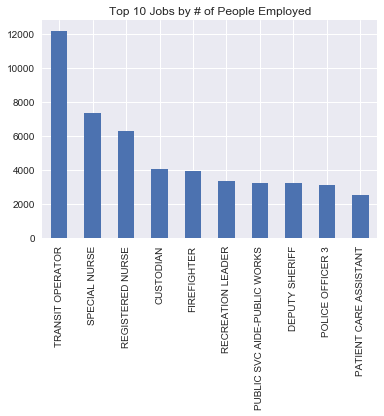

In [232]:
JobTitleCount = sf['JobTitle'].value_counts().head(10)
JobTitleCount.plot(title = "Top 10 Jobs by # of People Employed", kind = 'bar')

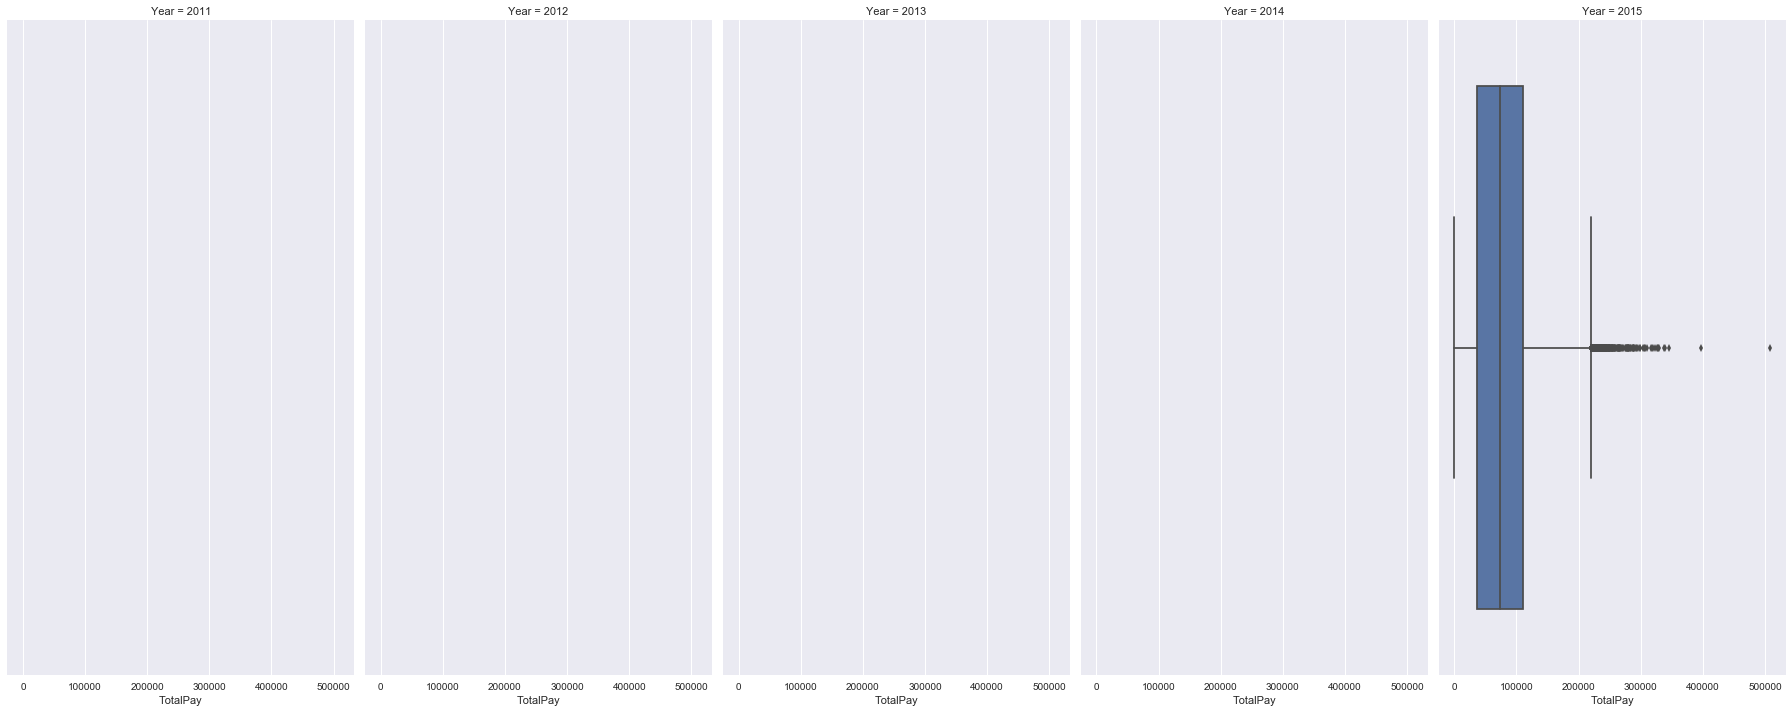

In [233]:
PayByYear = sns.FacetGrid(sf, col="Year", size=10, aspect=.5)
PayByYear = PayByYear.map(sns.boxplot, "TotalPay")

# If this tells us anything, is that there are some extreme outliers.

We can clearly see that there are some extreme outliers in this dataset.

Lets seperate the "High" and "Low" earners to look at them in greater detail.

In [234]:
HighEarners = sf[sf.TotalPay > 300000]
LowEarners = sf[sf.TotalPay < 4000]

In [235]:
pd.pivot_table(HighEarners, index=['JobTitle', 'EmployeeName', 'Year'], values=["TotalPay"])

TotalPay
JobTitle                       EmployeeName         Year           
ADM, SFGH MEDICAL CENTER       SUSAN CURRIN         2015  338390.32
ASST CHF OF DEPT (FIRE DEPT)   DAVID L FRANKLIN     2015  310743.63
                               THOMAS A SIRAGUSA    2015  323569.97
ASST MED EXAMINER              AMY P HART           2015  345100.51
                               ELLEN G MOFFATT      2015  397574.04
BATTALION CHIEF, FIRE SUPPRESS KIRK W RICHARDSON    2015  307202.45
                               SAMSON LAI           2015  305402.06
CHIEF INVESTMENT OFFICER       WILLIAM J COAKER JR. 2015  507831.60
CHIEF OF POLICE                GREGORY P SUHR       2015  328255.56
CHIEF, FIRE DEPARTMENT         JOANNE M HAYES-WHITE 2015  327774.39
DEPT HEAD V                    BARBARA A GARCIA     2015  307580.34
                               JOHN L MARTIN        2015  326764.01
DEPUTY CHIEF 3                 SHARON FERRIGNO      2015  316965.83
DEPUTY SHERIFF                 ANTONIO B SANTIAGO   2015  330205.58
EXECUTIVE CONTRACT EMPLOYEE    HARLAN L KELLY-JR    2015  320480.00
GEN MGR, PUBLIC TRNSP DEPT     EDWARD D REISKIN     2015  304000.40
SENIOR PHYSICIAN SPECIALIST    YIFANG QIAN          2015  337894.92
SUPERVISING PHYSICIAN SPEC     MILTON N ESTES       2015  317435.90

Above we see the 'JobTitles' and 'EmployeeNames' of the "High Earners", we additionally learn that many of them hold the position for more than one year.

We also see that JobTitles were changed between years, and as a result the same job could appear is distinct, lets create a new field called 'Department' later to hone in and compare departments.

There is also the addition of a middle name initial which is creating duplication in data.

In [236]:
pd.pivot_table(LowEarners, index=['JobTitle', 'EmployeeName', 'Year'], values=["TotalPay"])

TotalPay
JobTitle                       EmployeeName           Year          
ACCOUNT CLERK                  CICI WU                2015   2829.00
                               JOE W LAM              2015   2734.70
                               KIMBERLY J TAN         2015   3772.00
                               LATISHA SCARBOROUGH    2015   2829.00
                               OLIVIA L BOUDREAUX     2015   2148.75
ACCOUNTANT I                   ROSALINDA B TAN        2015    183.75
ACCOUNTANT II                  EMILY S CHESLEY        2015   2840.05
ACCOUNTANT IV                  PETER L CHIONG         2015    651.45
ADMIN HEARING EXAMINER         JAMES U HODGES         2015    261.84
ADMINISTRATIVE ANALYST         LAURA C GAASEMYR       2015    325.21
                               TERRY T LAM            2015   2841.00
ADMISSION ATTENDANT            ALEKSANDRA LIPKA-KADAJ 2015   2151.29
                               CRYSTAL R TAYLOR       2015   1334.92
                               GALA G SADURNI         2015    628.84
                               JEAN M JORDAN          2015     39.05
                               JOHN G COSMOS          2015     58.58
                               MARC A RANDALL         2015     58.58
                               SUZANNE K KENDALL      2015   3101.66
AIRPORT PROPERTY SPECIALIST 1  MARK BLISS             2015     88.11
ANESTHETIST                    STEPHANIE D LANGELAAR  2015   1240.44
APPRENTICE GARDENER            KENDALL T MILLENDER    2015   2868.00
                               KRISTOPHER K FINCHER   2015   2868.00
                               RAYMONE D REED         2015   2868.00
                               TONI D JEFFERSON       2015   2868.00
APRNT  STATIONARY ENGINEER I   ANDY C SUEN            2015   2181.00
                               LUNA K MAIA            2015   2181.00
APRNTC STNRY ENG, SEW PLANT 1  FRANCISCO RAMOS        2015   1088.02
ARBORIST TECHNICIAN            ANDREW J ENZI          2015   2715.94
ARCHITECTURAL ASSISTANT 1      MELISSA T HUNG         2015    152.05
ARCHITECTURAL ASSISTANT 2      DANIELLE MAYO-CHACON   2015   3044.19
...                                                              ...
TRANSIT OPERATOR               YVETTE JOHNS           2015    250.00
                               ZHI JIE ZHAO           2015    250.00
TRANSIT PAINT SHOP SPRV1       CAROLE M GILBERT       2015    961.18
TRANSIT POWER LINE WORKER      DONALD LANDRY          2015    311.62
TRANSIT SUPERVISOR             HERBERT Y YEE          2015    121.57
                               JAMES N WILLIAMS       2015    150.00
                               KERMIT J ARNOLD        2015    150.00
                               LARRY DAVIS            2015   3221.06
                               MOON S LAU             2015   1079.10
                               RAMON MOLINA           2015   1045.80
TRUCK DRIVER                   AVERY L JACKSON        2015   2149.35
                               CONRAD LARAN           2015   3648.42
                               DANIEL HERNANDEZ       2015   3248.54
                               JOHN A MELENDEZ        2015    176.18
                               JOHN E LONG            2015   3137.69
                               MICHAEL W VENTURI      2015    859.71
                               STEVEN R JENKINS       2015    309.12
                               THOMAS D TAYLOR        2015   3265.90
                               THOMAS E COLLINS       2015   1688.24
UNIT CLERK                     ANA CASTRO             2015   2765.67
                               IMOGENE JONES          2015      0.00
                               RADEAN SEELEY          2015    881.21
VICTIM & WITNESS TECHNICIAN    GRACIELA B CRUZ        2015   3623.91
VICTIM/WITNESS INVESTIGATOR 1  FERDINAND T LAXAMANA   2015   2337.00
                               MICHAEL R SLY          2015   2337.00
WATER METER REPAIRER           THOMAS MATTIAS         2015

In [237]:
# Create a new column called 'Department'
sf['Department'] = ''

When looking at the 'JobTitles' it is clear that employees can be grouped easily into certain departments such as below:

In [238]:
sf.loc[sf.JobTitle.str.contains('POLICE'), 'Department'] = "POLICE"
sf.loc[sf.JobTitle.str.contains("FIRE"), 'Department'] = "FIRE"
sf.loc[sf.JobTitle.str.contains("MEDICAL"), 'Department'] = "MEDICAL"
sf.loc[sf.JobTitle.str.contains("NURSE"), 'Department'] = "MEDICAL"
sf.loc[sf.JobTitle.str.contains("TRANSIT"), 'Department'] = "TRANSIT"

In [239]:
# Applying $ (currency) for formatting and attractive presentation

ByDepartment = pd.pivot_table(sf, index=['Department'], values=["TotalPay"], aggfunc=[np.sum, np.mean, len], fill_value=0)
ByDepartment.ix[:,0] = ['${:,.2f} MM'.format(x) for x in ByDepartment.ix[:,0]/1000000]
ByDepartment.ix[:,1] = ['${:,.2f}'.format(x) for x in ByDepartment.ix[:,1]]
ByDepartment

,sum,mean,len
,TotalPay,TotalPay,TotalPay
Department,,,
,"$2,053.73 MM","$72,437.00",135725
FIRE,$230.77 MM,"$148,596.00",7432
MEDICAL,$306.79 MM,"$77,688.00",19013
POLICE,$224.83 MM,"$111,139.00",10224
TRANSIT,$236.70 MM,"$67,571.00",15636


In the above table we can see the total of pay, average pay and count per Department

In [159]:
# https://www.kaggle.com/dmitriy19/d/kaggle/sf-salaries/explore-sf-salary-data-quick-eda

In [160]:
# Are there any duplicate names in the dataset?

In [161]:
# Which employee has been employed three years?

In [162]:
# What is the correlation between titles and salaries?

## THIS IS WHERE I STOPPED

In [245]:
## http://seaborn.pydata.org/generated/seaborn.regplot.html

Police2014 = sf[(sf.Department == 'POLICE') & (sf.Year == 2015) & (sf.Status != 'PT')]
# Police2014_Pivot = pd.pivot_table(Police2014, index=['JobTitle'], values=["TotalPay"], aggfunc=[np.sum])
Police2014
#Police2014_Pivot
# sns.regplot('JobTitle', 'TotalPay', data=Police2014)

,BasePay,Benefits,EmployeeName,Id,JobTitle,OtherPay,OvertimePay,Status,TotalPay,Year,Department
148657,308901.44,82682.53,GREGORY P SUHR,NaN,CHIEF OF POLICE,19354.12,0.00,FT,328255.56,2015,POLICE
148816,118111.85,36424.35,SAM W YUEN,NaN,POLICE OFFICER 2,9275.70,128916.77,FT,256304.32,2015,POLICE
148925,157411.23,40942.22,RYAN J JONES,NaN,POLICE OFFICER 2,18786.42,59909.01,FT,236106.66,2015,POLICE
148935,119633.51,36354.13,ARNOLD J BORGEN,NaN,POLICE OFFICER,24681.47,95356.42,FT,239671.40,2015,POLICE
148949,133792.01,41246.77,DAVID KAMITA,NaN,POLICE OFFICER 3,90072.45,10000.16,FT,233864.62,2015,POLICE
148972,215611.14,56593.78,RICHARD-ALVIN G YICK,NaN,POLICE OFFICER 3,725.32,0.00,FT,216336.46,2015,POLICE
148974,215524.34,56533.92,RAUL E ELIAS,NaN,POLICE OFFICER 3,825.98,0.00,FT,216350.32,2015,POLICE
148995,122683.78,37935.89,THOMAS J SMITH,NaN,POLICE OFFICER 3,45908.36,65190.33,FT,233782.47,2015,POLICE
149057,132388.75,36860.65,MICHAEL TURSI,NaN,POLICE OFFICER 3,10568.72,86496.86,FT,229454.33,2015,POLICE
149088,120720.16,39163.92,SUSAN ROLOVICH,NaN,POLICE OFFICER 3,10936.06,94127.85,FT,225784.07,2015,POLICE


In [163]:
# How have salaries changed between the years?

In [164]:
# Can you make a bar plot or a histogram?

In [165]:
# Can you compare two related quantities?

In [166]:
# Can you make a scatterplot?

In [167]:
# Can you make a time-series plot?

In [168]:
# How have salaries changed over time between different groups of people?

In [169]:
# How are base pay, overtime pay and benefits allocated between different groups?

In [170]:
# Can we split the dataset between males and females?

In [171]:
# Is there any evidene of pay discrimination based on gender in this dataset?

In [172]:
# How is budget allocated based on different groups and responsibilities?

In [274]:
# Any 80/20 principals I can identify?

In [277]:
# Integrate ideas from here:
# https://public.tableau.com/profile/lawrence.chernin#!/vizhome/SanFranciscoSalaries/CountsbyTitle

## Probably will not be used:

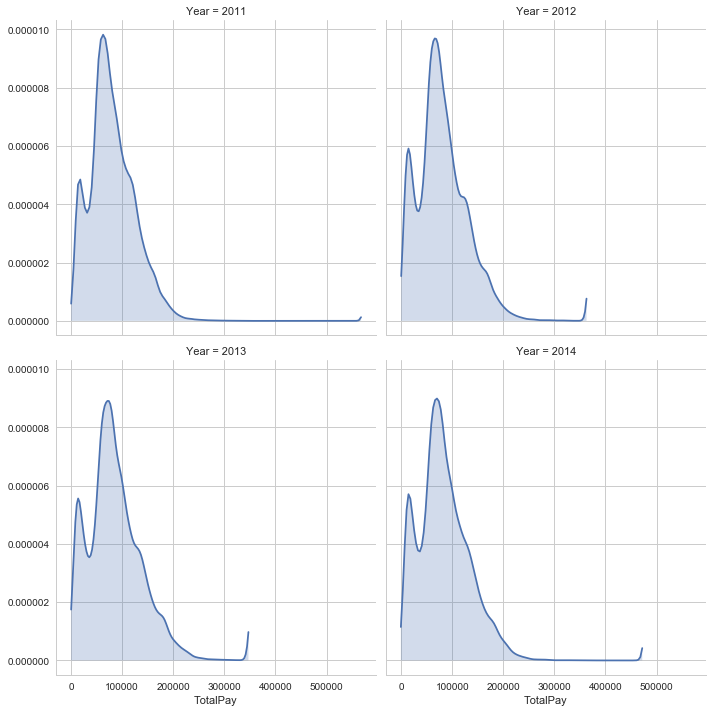

In [514]:
# Probably should delete this
TotalPay = sns.FacetGrid(sf, col="Year", col_wrap=2, size=5, dropna=True)
sns.set_style("whitegrid")
TotalPay.map(sns.kdeplot, 'TotalPay', shade=True, cut=0);